In [1]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net,MoreLayersNet

In [2]:
n_epoch = 1000000 #エポック
batchsize = 178 #バッチサイズ
bprop_len = 200 #何回でバックプロパゲーションを打ち切るか(truncate)
n_units = 2000 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [3]:
xp = cuda.cupy if use_gpu is True else np

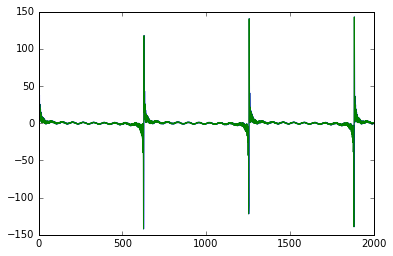

In [4]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[7])
    train_data_y.append(row[7])
raw_data = np.asarray(train_data_x, dtype=np.float32)
raw_data = np.asarray([math.sin(0.1 * x) for x in range(10000)], dtype = np.float32)
for i in range(200):
    for j in range(len(raw_data)):
        raw_data[j] = raw_data[j] + math.sin(i * 0.01 * j)
train_data_x = raw_data[:-1]
train_data_y = raw_data[1:]
plt.plot(train_data_x[:2000])
plt.plot(train_data_y[:2000])

In [5]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [6]:
model = MoreLayersNet(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam(alpha=0.0001)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 100 == 0:
            print('epoch {}, error {}, alpha{}'.format(epoch, loss_data / length, optimizer.lr))

        loss.append(loss_data / length)
        loss_data = 0
        #model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()
    

epoch 100, error 72.99113464355469, alpha1.733334117999442e-05
epoch 200, error 68.33264923095703, alpha2.320953855779739e-05
epoch 300, error 66.52747344970703, alpha2.8233395349021975e-05
epoch 400, error 64.81004333496094, alpha3.242108946391083e-05
epoch 500, error 62.91938400268555, alpha3.603229161572538e-05
epoch 600, error 62.8537712097168, alpha3.9226406608642874e-05
epoch 700, error 61.285911560058594, alpha4.21005484946398e-05
epoch 800, error 59.43280029296875, alpha4.471849931246902e-05
epoch 900, error 63.488990783691406, alpha4.712486915192238e-05
epoch 1000, error 55.4473876953125, alpha4.9352375539769744e-05
epoch 1100, error 47.411983489990234, alpha5.1425906712488785e-05
epoch 1200, error 46.94205093383789, alpha5.336495129470248e-05
epoch 1300, error 43.63215255737305, alpha5.518513279824824e-05
epoch 1400, error 45.28757858276367, alpha5.689922245164233e-05
epoch 1500, error 39.10532760620117, alpha5.851783243061366e-05
epoch 1600, error 37.8724365234375, alpha6.00

KeyboardInterrupt: 

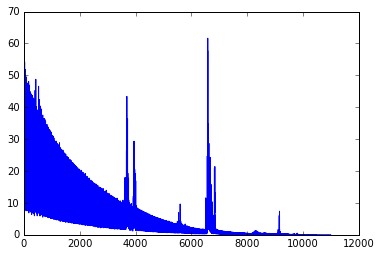

In [7]:
plt.plot(loss[1000:])

In [8]:
output = evaluate(model,2000,origin=0)

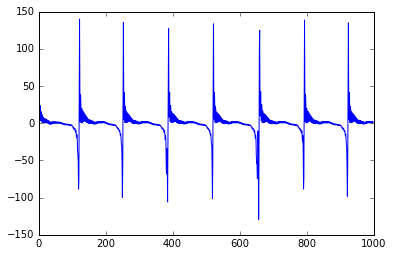

In [9]:
plt.plot(output[0:1000])